In [3]:
# elimina os warnings das bibliotecas
import warnings
warnings.filterwarnings("ignore")

[*********************100%***********************]  1 of 1 completed
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 248 entries, 2023-03-30 to 2024-03-28
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       248 non-null    float64
 1   High       248 non-null    float64
 2   Low        248 non-null    float64
 3   Close      248 non-null    float64
 4   Adj Close  248 non-null    float64
 5   Volume     248 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 13.6 KB


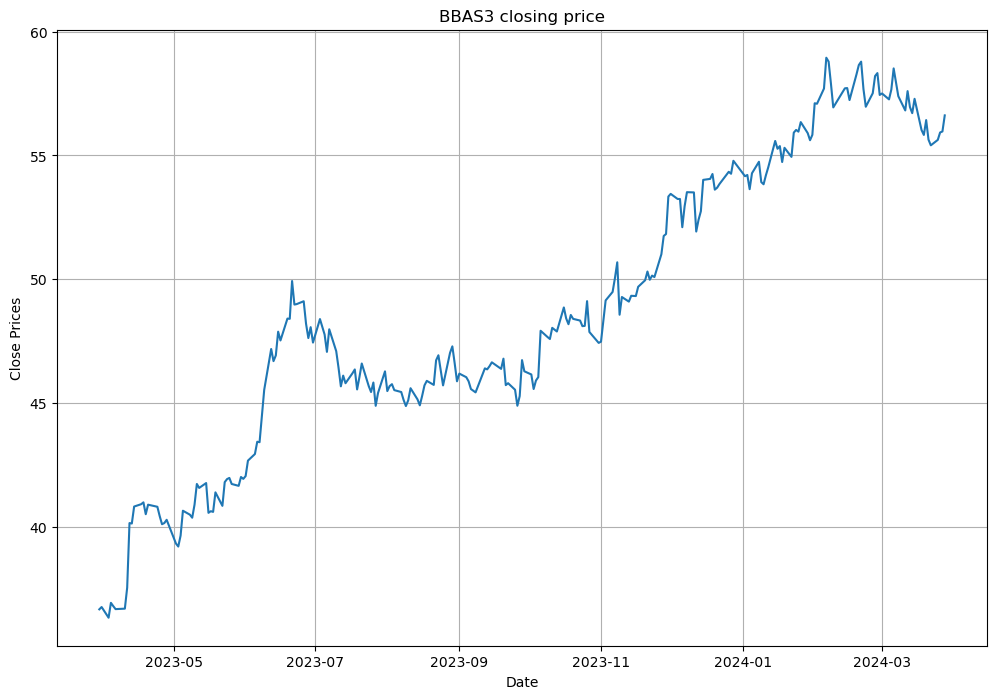

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,1,1)[40] intercept   : AIC=inf, Time=8.28 sec
 ARIMA(0,0,0)(0,1,0)[40] intercept   : AIC=1040.993, Time=0.12 sec
 ARIMA(1,0,0)(1,1,0)[40] intercept   : AIC=491.176, Time=3.18 sec
 ARIMA(0,0,1)(0,1,1)[40] intercept   : AIC=inf, Time=6.31 sec
 ARIMA(0,0,0)(0,1,0)[40]             : AIC=1211.153, Time=0.12 sec
 ARIMA(1,0,0)(0,1,0)[40] intercept   : AIC=527.753, Time=0.59 sec
 ARIMA(1,0,0)(2,1,0)[40] intercept   : AIC=482.341, Time=11.54 sec
 ARIMA(1,0,0)(2,1,1)[40] intercept   : AIC=484.051, Time=17.56 sec
 ARIMA(1,0,0)(1,1,1)[40] intercept   : AIC=482.397, Time=7.51 sec
 ARIMA(0,0,0)(2,1,0)[40] intercept   : AIC=inf, Time=8.08 sec
 ARIMA(2,0,0)(2,1,0)[40] intercept   : AIC=481.944, Time=14.42 sec
 ARIMA(2,0,0)(1,1,0)[40] intercept   : AIC=490.745, Time=4.10 sec
 ARIMA(2,0,0)(2,1,1)[40] intercept   : AIC=483.723, Time=19.80 sec
 ARIMA(2,0,0)(1,1,1)[40] intercept   : AIC=482.234, Time=8.85 sec
 ARIMA(3,0,0)(2,1,0)[40] intercept   : 

,Adj Close
Date,
2023-03-30,36.661331
2023-03-31,36.755310
2023-04-03,36.323009
2023-04-04,36.924477
2023-04-05,36.792904
...,...
2024-03-22,55.410000
2024-03-25,55.630001
2024-03-26,55.930000


<Figure size 2000x500 with 0 Axes>

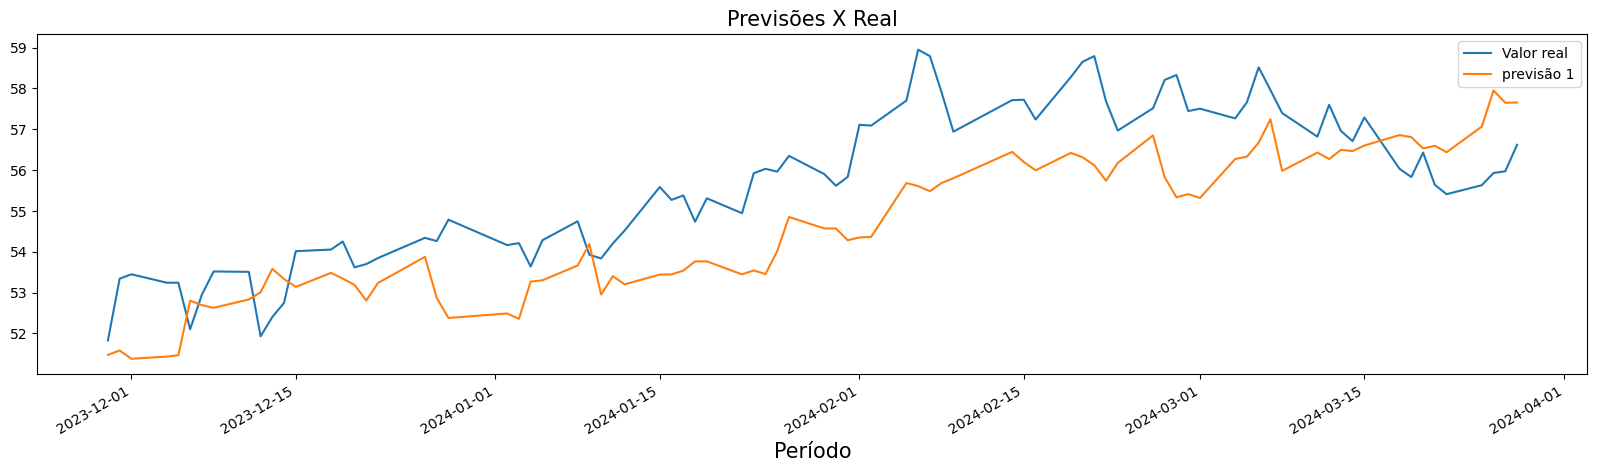

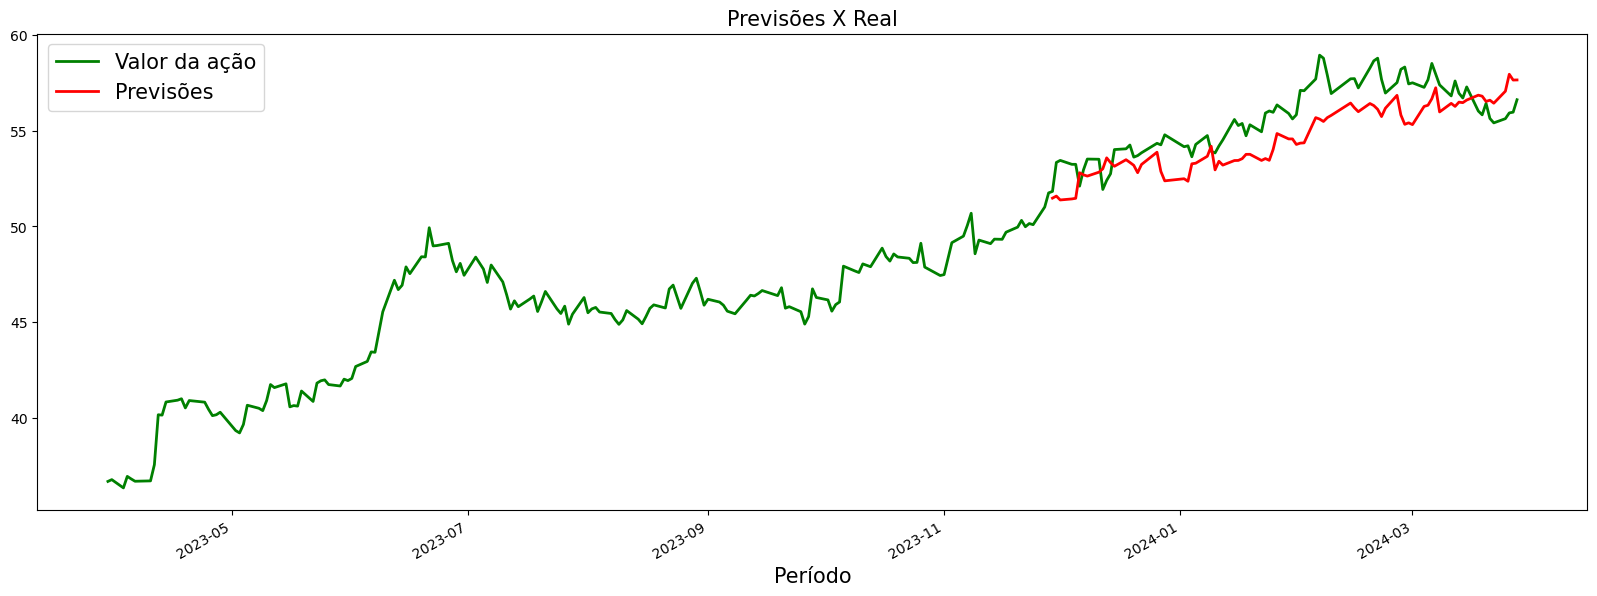


Performance no Conjunto de Teste:
Mean Squared Error (MSE): 2.494375026679253
Median Absolute Deviation (MAD): 1.323230914775511
Mean Absolute Error (MAE): 1.3898150934688376
R-squared (R²): 0.27639031089065214


In [4]:
# Importação das bibliotecas necessárias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from pmdarima.arima import auto_arima
import pmdarima as pm
from matplotlib.pyplot import rcParams
rcParams['figure.figsize']=15,6

# Importação de funções e constantes específicas
from functions.stock import download_stock_data
from const.interval import Interval

# Download dos dados históricos das ações
stock_data = download_stock_data("BBAS3.SA", Interval.DAY.value, 365)

# Exibição das informações dos dados
stock_data.info()

# Plotagem do preço de fechamento das ações
plt.figure(figsize=(12,8))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(stock_data['Adj Close'])
plt.title('BBAS3 closing price')
plt.show()

# Seleção e limpeza dos dados relevantes
data = stock_data[["Adj Close"]].copy()
data.dropna(inplace=True)

# Ajuste automático do modelo ARIMA usando auto_arima
stepwise=auto_arima(data,
                    start_p=0,
                    start_q=0,
                    d=0,
                    max_p=3,
                    max_q=3,
                    max_d=3,
                    start_P=1,
                    start_Q=1,
                    D=1,
                    max_P=2, max_D=1, max_Q=2, max_order=5,
                    m=40,
                    seasonal=True,
                    trace=True,
                    error_action='ignore',suppress_warnings=True,
                    stepwise=True)

# Exibição do AIC e BIC do modelo ajustado
print(stepwise.aic())
print(stepwise.bic())

# Visualização dos dados
display(data)

# Divisão dos dados em conjuntos de treinamento e teste
train_size = int(len(data) * 0.67)
test_size = len(data) - train_size
treino, teste = data[0:train_size], data[train_size:len(data)]

# Ajuste do modelo ARIMA aos dados de treinamento
stepwise.fit(treino)

# Geração de previsões com base no modelo ajustado
previsao=stepwise.predict(n_periods=len(teste))

# Transformação das previsões em um DataFrame
previsao_final=pd.DataFrame(previsao.values,index=teste.index, columns=["Adj Close"])

# Plotagem das previsões vs. teste
plt.figure(figsize=(20,5))
pd.concat([teste,previsao_final],axis=1).plot(figsize=(20,5))
plt.xlabel('')
plt.title('Previsões X Real',size=15)
plt.xlabel("Período", size=15)
plt.legend(['Valor real','previsão 1'])

# Plotagem das previsões vs. dados reais
pd.concat([data,previsao_final],
          axis=1).plot(linewidth=2,
                       figsize=(20,7),
                       color=['g','r'])
plt.legend(['Valor da ação','Previsões'], fontsize=15)
plt.xlabel('Período', size=15)
plt.title('Previsões X Real',size=15)
plt.show()

# Exibição do resumo do modelo ajustado
stepwise.summary()

# Avaliação de desempenho das previsões
from functions.validation import performance_evaluation
test_performance = performance_evaluation(teste, previsao_final)

print("\nPerformance no Conjunto de Teste:")
for metric, value in test_performance.items():
    print(f'{metric}: {value}')


[CV] fold=0 ..........................................................
[CV] fold=1 ..........................................................
[CV] fold=2 ..........................................................
[CV] fold=3 ..........................................................
[CV] fold=4 ..........................................................
[CV] fold=5 ..........................................................
[CV] fold=6 ..........................................................
[CV] fold=7 ..........................................................
[CV] fold=8 ..........................................................
[CV] fold=9 ..........................................................
[CV] fold=10 .........................................................
[CV] fold=11 .........................................................
[CV] fold=12 .........................................................
[CV] fold=13 .........................................................
[CV] f

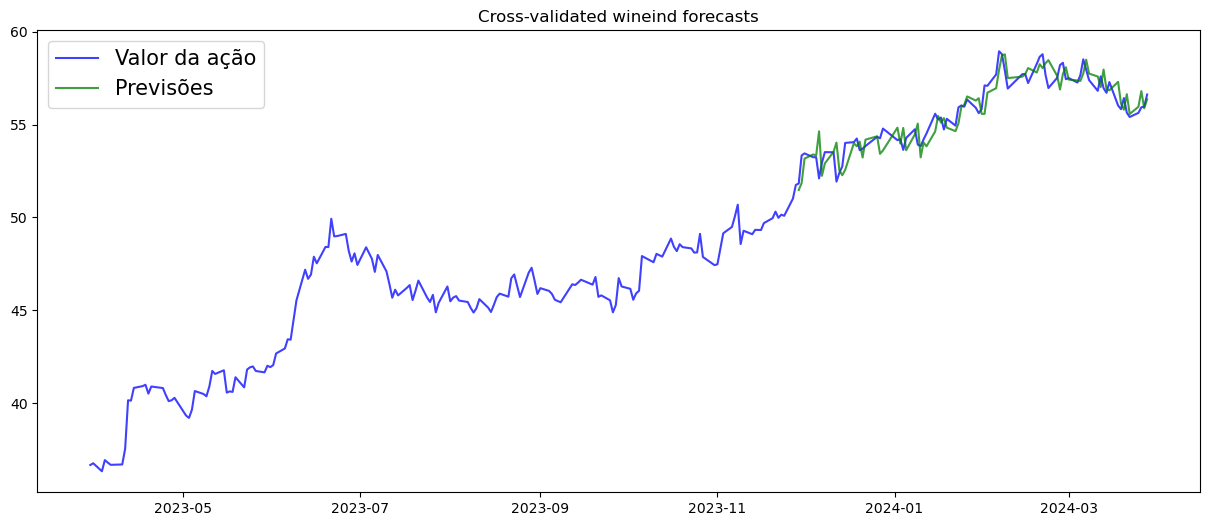


Performance no Conjunto de Teste:
Mean Squared Error (MSE): 0.5680630653442924
Median Absolute Deviation (MAD): 0.4741883881960156
Mean Absolute Error (MAE): 0.5839047154692211
R-squared (R²): 0.8352068419096053


In [5]:
# Execução da validação cruzada

from pmdarima import model_selection

y = data
est = pm.ARIMA(order=(1, 0, 1),
               seasonal_order=(2, 1, 0, 40),
               suppress_warnings=True)
cv = model_selection.SlidingWindowForecastCV(window_size=166, step=1, h=1)
predictions = model_selection.cross_val_predict(
    est, y, cv=cv, verbose=2, averaging="median")

# Plotagem das previsões sobre a série original
x_axis = np.arange(y.shape[0])
n_test = predictions.shape[0]

plt.plot(y.index, y, alpha=0.75, c='b')
plt.plot(y.index[-n_test:], predictions, alpha=0.75, c='g')  # Forecasts
plt.legend(['Valor da ação','Previsões'], fontsize=15)
plt.title("Cross-validated wineind forecasts")
plt.show()

# Avaliação de desempenho das previsões da validação cruzada
y_true = y[-n_test:]  
test_performance = performance_evaluation(y_true, predictions)

print("\nPerformance no Conjunto de Teste:")
for metric, value in test_performance.items():
    print(f'{metric}: {value}')